# 02 — Size Distributions & Baselines

This notebook establishes descriptive baselines for PV system size.

It uses only records deemed temporally valid by Notebook 01.
It does not introduce new canonical fields.
It does not perform modeling or prediction.

---

## Question

How does installed system size distribute across time and context once temporal validity is enforced?

---

## Inputs

- Canonical `installation_year`
- Raw `pv_system_size_dc`
- Diagnostics from Notebook 01

---

## Outputs

- Year-level size distributions
- Cohort-conditioned descriptive baselines
- Identification of structural irregularities (not explanations)

---

## Scope Boundary

This notebook performs:
- filtering based on prior validation
- descriptive statistics
- distributional inspection
- cohort comparisons

It does **not** perform:
- feature engineering beyond grouping
- regression or forecasting
- causal interpretation


In [11]:
import pandas as pd
import os
import numpy as np
from pathlib import Path

In [12]:
canonical_path = Path("../outputs/canonical/installation_year.csv")
diagnostics_path = Path("../outputs/diagnostics/installation_date_violations.csv")

installation_year = pd.read_csv(canonical_path)
diagnostics = pd.read_csv(diagnostics_path)

In [13]:
# Load raw data (assumed schema-admitted by Notebook 01)
# Load raw data (assumed schema-admitted by Notebook 01)
df = pd.read_parquet(
    Path(os.environ["TRACKING_THE_SUN_DATA"]),
    engine="pyarrow"
)


In [14]:
raw_size = df[["pv_system_size_dc"]].copy()

In [16]:
analysis_df = diagnostics.merge(
    raw_size,
    left_index=True,
    right_index=True
)

analysis_df = analysis_df.query("violation == 'valid'")

print(f"Rows retained for analysis: {analysis_df.shape[0]}")



Rows retained for analysis: 1920983


In [17]:
analysis_df["pv_system_size_dc"].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

count    1.920983e+06
mean     9.358770e+00
std      5.214370e+01
min     -1.000000e+00
1%      -1.000000e+00
5%       2.340000e+00
50%      5.800000e+00
95%      1.372000e+01
99%      4.284000e+01
max      1.253224e+04
Name: pv_system_size_dc, dtype: float64

In [18]:
yearly_summary = (
    analysis_df
    .groupby("installation_year")["pv_system_size_dc"]
    .describe(percentiles=[0.1, 0.5, 0.9])
)

yearly_summary.head()

,count,mean,std,min,10%,50%,90%,max
installation_year,,,,,,,,
1998.0,20.0,10.001066,29.082809,0.462000,0.932160,2.347800,9.140690,132.817630
1999.0,95.0,4.523546,9.798216,0.819572,1.405680,2.828400,6.354463,96.390000
2000.0,116.0,5.267685,14.753168,0.512233,1.150745,2.768916,6.342000,115.038892
2001.0,1085.0,4.069398,10.236359,0.300000,1.430400,2.859120,5.774995,230.100000
2002.0,2032.0,7.791733,33.411504,0.223200,1.485960,3.000000,9.000000,791.925466


<Figure size 640x480 with 0 Axes>

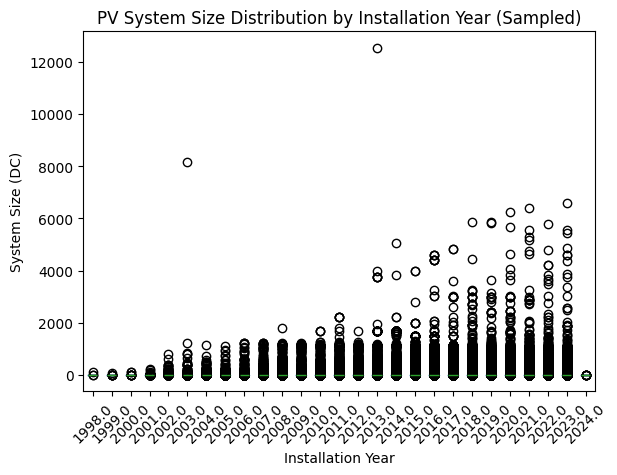

In [19]:
import matplotlib.pyplot as plt

# Sample years to avoid overplotting
years = sorted(analysis_df["installation_year"].unique())
sample_years = years[::max(1, len(years)//15)]

plot_df = analysis_df[
    analysis_df["installation_year"].isin(sample_years)
]

plt.figure()
plot_df.boxplot(
    column="pv_system_size_dc",
    by="installation_year",
    grid=False,
    rot=45
)

plt.title("PV System Size Distribution by Installation Year (Sampled)")
plt.suptitle("")
plt.xlabel("Installation Year")
plt.ylabel("System Size (DC)")
plt.show()


In [20]:
yearly_summary["p90_p10_ratio"] = (
    yearly_summary["90%"] / yearly_summary["10%"]
)

yearly_summary.sort_values("p90_p10_ratio", ascending=False).head(10)

,count,mean,std,min,10%,50%,90%,max,p90_p10_ratio
installation_year,,,,,,,,,
1998.0,20.0,10.001066,29.082809,0.462000,0.932160,2.347800,9.140690,132.817630,9.805924
2005.0,3964.0,9.748836,41.834278,0.480000,1.600000,3.960000,11.355040,1124.974721,7.096900
2004.0,4408.0,8.451446,34.838344,0.395567,1.650000,3.675000,10.467391,1160.025877,6.343874
2002.0,2032.0,7.791733,33.411504,0.223200,1.485960,3.000000,9.000000,791.925466,6.056691
2000.0,116.0,5.267685,14.753168,0.512233,1.150745,2.768916,6.342000,115.038892,5.511211
2008.0,10364.0,15.472736,75.198121,0.297439,2.100000,4.320000,11.340000,1806.119132,5.400000
2003.0,2622.0,12.981816,166.237718,0.377528,1.980000,3.300000,10.533480,8168.807156,5.319939
2010.0,19903.0,10.684543,59.036435,0.344704,2.160000,4.950000,10.500000,1689.048474,4.861111
2007.0,9746.0,11.474301,57.676406,0.240000,2.240000,4.464000,10.880000,1214.859167,4.857143
